# Improving Bank Marketing with Machine Learning
### Group 7 - Gary Bair, Hunter Blum, Jacqueline Urenda

### Libraries

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor



# Sklearn packages
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

# DMBA packages

### Read in Data

In [2]:
bank = pd.read_csv("bank-additional-full.csv", delimiter=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## EDA

### Structure
Dimensions

In [3]:
print("The data has", bank.shape[1], "features.")
print("The data has", bank.shape[0], "observations.")

The data has 21 features.
The data has 41188 observations.


Data Types

In [4]:
bank.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [5]:
bank.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp.var.rate        10
cons.price.idx      26
cons.conf.idx       26
euribor3m          316
nr.employed         11
y                    2
dtype: int64

### NAs
By column - Looks like we don't have to worry about NAs

In [6]:
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

### Distribution of Label

C:\Users\hunte\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Distribution of Term Deposits')

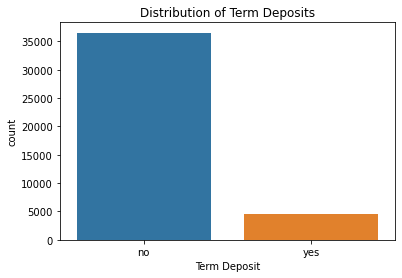

In [7]:
sns.countplot(bank['y'])
plt.xlabel("Term Deposit")
plt.title("Distribution of Term Deposits")

In [8]:
y_count = bank.groupby(['y'])['y'].count()
yes_per = round(y_count.yes/bank.shape[0]*100,2)
no_per = round(y_count.no/bank.shape[0]*100,2)

print(y_count.yes, "(" + str(yes_per) + "%)", "of observations responded yes to a term deposit")
print(y_count.no, "(" + str(no_per) + "%)", "of observations responded no to a term deposit")


4640 (11.27%) of observations responded yes to a term deposit
36548 (88.73%) of observations responded no to a term deposit


### Encode Categorical Variables
Target variable is now y_yes

In [38]:
OH_encoder = OneHotEncoder(drop = 'if_binary', sparse=False)
bank_coded = OH_encoder.fit_transform(bank_cat)
bank_coded = pd.DataFrame(bank_coded, columns = OH_encoder.get_feature_names_out())
bank_coded = pd.concat([bank_coded, bank_num], axis = 1)
bank_coded.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


### Correlation Matrix

<AxesSubplot:>

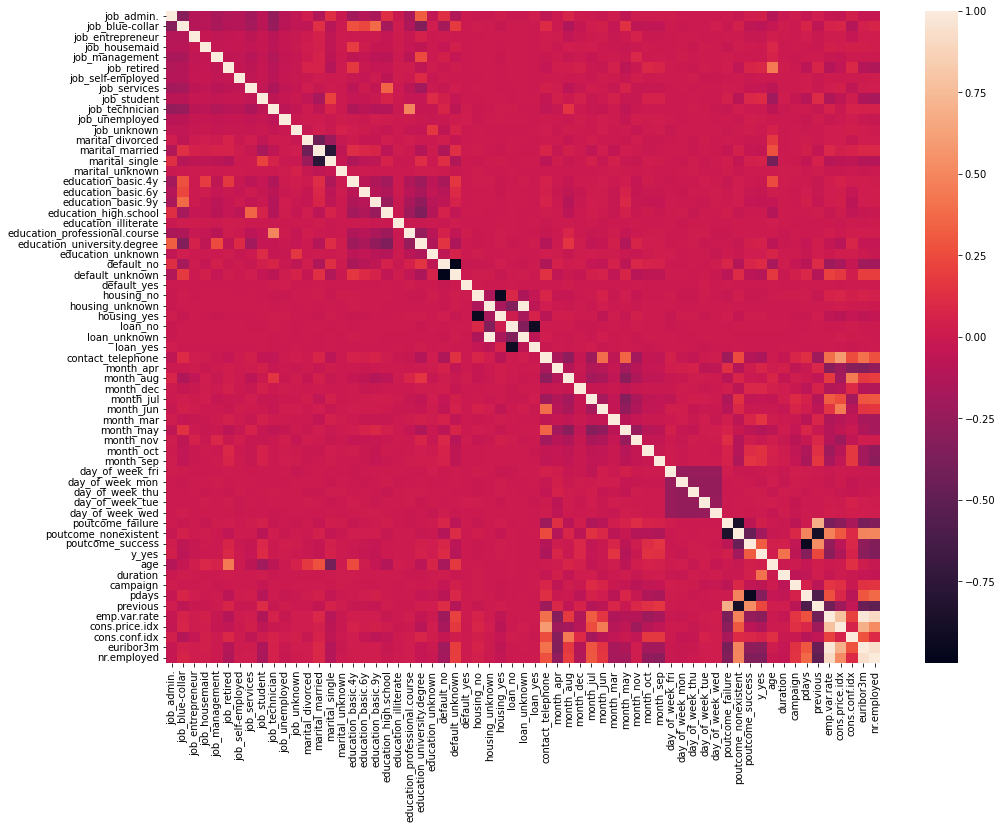

In [41]:
plt.figure(figsize = (16,12))
sns.heatmap(bank_coded.corr())

### Feature Selection
Zero Variance Variables

In [46]:
X = bank_coded.drop(columns = ['y_yes'])
y = bank_coded['y_yes']
low_var = VarianceThreshold(threshold=0.1)
low_var.fit(X)
dropcols = [column for column in X.columns
           if column not in
X.columns[low_var.get_support()]]
for features in dropcols:
    print(features)
    
X_highvar = X.drop(dropcols, axis = 1)

job_entrepreneur
job_housemaid
job_management
job_retired
job_self-employed
job_services
job_student
job_unemployed
job_unknown
marital_divorced
marital_unknown
education_basic.4y
education_basic.6y
education_illiterate
education_unknown
default_yes
housing_unknown
loan_unknown
month_apr
month_dec
month_mar
month_nov
month_oct
month_sep
poutcome_failure
poutcome_success


,job_admin.,job_blue-collar,job_technician,marital_married,marital_single,education_basic.9y,education_high.school,education_professional.course,education_university.degree,default_no,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41184,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6
41185,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6
41186,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6


Multicollinearity

In [65]:
X_vif = pd.DataFrame()
X_vif['variable'] = X_highvar.columns
X_vif['vif'] = [variance_inflation_factor(X_highvar.values, i)
               for i in range(len(X_highvar.columns))]
# housing_no and loan_no were perfectly correlated with their counterparts so we'll remove them
X_clean = X_highvar.drop(columns = ['housing_no', 'loan_no'])
X_vif = pd.DataFrame()
X_vif['variable'] = X_clean.columns
X_vif['vif'] = [variance_inflation_factor(X_clean.values, i)
               for i in range(len(X_clean.columns))]
drop = list(X_vif[X_vif['vif']>10].variable)
X_clean = X_clean.drop(columns = drop, axis = 1)

C:\Users\hunte\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


## Modelling
### Split Data
Note: Planning on using CV for tuning, so just doing a train and test split

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=123)